In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_paths = []
for root, dirs, files in os.walk("/kaggle/input/face-clustering-results"):
    for file in files:
        full_path = os.path.join(root, file)
        file_paths.append(full_path)

# Now file_paths contains all the file paths from the unzipped folder
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Age Preprocessing
Because the Age is a range and not a categorical value we will want to group ages by ranges 

In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from math import log2



# Load and combine all cluster data
data_frames = []
for f in file_paths:
    cluster_id = f.split(".")[0].split("_")[-1]  # assuming filename like cluster_0.xlsx
    df = pd.read_excel(f)
    # If the cluster_id is not in the dataframe, add it
    df['SOURCE_FILE'] =  f
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)
all_data['AGE_GROUP'] = pd.cut(all_data['Age'], bins=[0, 18, 30, 50, 100], labels=['Child','Young','Adult','Senior'])
all_data = all_data.dropna(subset=['AGE_GROUP', 'SOURCE_FILE'])

all_data.head()

/tmp/ipykernel_24/4027243413.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat(data_frames, ignore_index=True)


,Age,Gender,Ethnicity,Pixel Intensity,SOURCE_FILE,AGE_GROUP
0,100,0.0,0,91.125000,/kaggle/input/face-clustering-results/Results_...,Senior
1,100,1.0,0,111.341825,/kaggle/input/face-clustering-results/Results_...,Senior
2,100,1.0,0,65.675550,/kaggle/input/face-clustering-results/Results_...,Senior
3,100,1.0,0,66.699875,/kaggle/input/face-clustering-results/Results_...,Senior
4,100,1.0,2,85.694375,/kaggle/input/face-clustering-results/Results_...,Senior


## Ethnicity Preprocessing


In [20]:
all_data = all_data[all_data['Ethnicity'] <= 4]

## Pixel Intensity Preprocessing
While the Pixel Intensity is not a feature of the dataset - its a metadata of the underlying image vectors . we want see if there is a pixel intensity change between the clusters.

The Pixel Intensity value varies between 0 to 255 , because its a large range we will normalize it.


In [37]:
from sklearn.preprocessing import MinMaxScaler

# Normalize Pixel Intensity
scaler = MinMaxScaler()
all_data['Pixel_Intensity_Normalized'] = scaler.fit_transform(all_data[['Pixel Intensity']])

all_data.head()


,Age,Gender,Ethnicity,Pixel Intensity,SOURCE_FILE,AGE_GROUP,Pixel_Intensity_Normalized
0,100,0.0,0,91.125000,/kaggle/input/face-clustering-results/Results_...,Senior,0.370505
1,100,1.0,0,111.341825,/kaggle/input/face-clustering-results/Results_...,Senior,0.452829
2,100,1.0,0,65.675550,/kaggle/input/face-clustering-results/Results_...,Senior,0.266872
3,100,1.0,0,66.699875,/kaggle/input/face-clustering-results/Results_...,Senior,0.271044
4,100,1.0,2,85.694375,/kaggle/input/face-clustering-results/Results_...,Senior,0.348391


### Purity Metric 
Purity is a simple and intuitive measure used to evaluate the quality of a clustering outcome against a known set of class labels. The idea is to assess how "pure" or homogeneous each discovered cluster is with respect to the true categories of the data.

**How It Works:**

1. *Definition:*
    Suppose you have a set of data points that were grouped into clusters by an unsupervised algorithm, and you also have ground-truth class labels (like ethnicity categories or age groups). For each cluster, you identify which ground-truth label is most common in that cluster. The purity of that cluster is the fraction of points in it that belong to this most common class.

2. *Calculation:*
After determining the majority class in each cluster, you compute the ratio of the number of points from that class to the total number of points in the cluster. This gives a number between 0 and 1, where 1 means the cluster contains only members of a single class (perfect purity) and lower values indicate more mixed or heterogeneous clusters.

3. *Overall Purity:*
To get the overall purity of the clustering solution, you typically take a weighted average of the cluster purities, where the weighting is based on the cluster sizes. The closer this average is to 1, the more closely the clusters reflect the actual class labels.

**What Purity Tells You:**

1. *High Purity:*
Clusters are well-aligned with known categories. For instance, if purity is high when considering ethnicity, it means each cluster predominantly contains individuals from a single ethnic group.

2. *Low Purity:*
Clusters mix different classes together. This could mean the clustering method is not capturing the distinctions you care about, or the data features do not separate those classes well.

In [21]:

# ---- Compute Purity by Column of CLUSTER and Algorithm ----
def cluster_purity_by_algorithm(df, cluster_col, label_col, algorithm):
    purities = {}
    for c_id, group in df.groupby(cluster_col):
        base_name = os.path.basename(c_id)
        if algorithm.lower() in base_name.lower():  # Case-insensitive check
            counts = group[label_col].value_counts()
            if not counts.empty:  # Handle case where no valid label counts exist
                max_count = counts.iloc[0]
                purity = max_count / len(group)
                purities[c_id] = purity
    return purities
    
def calculate_metric_measures(purity_list):
    return (max(purity_list,default=0) , sum(purity_list),sum(purity_list)/len(purity_list))

    

# ethnicity_purity_kmeans = cluster_purity(all_data, 'SOURCE_FILE', 'Ethnicity',"kmeans")
# ethnicity_purity_som = cluster_purity(all_data, 'SOURCE_FILE', 'Ethnicity',"som")
# ethnicity_purity_birch = cluster_purity(all_data, 'SOURCE_FILE', 'Ethnicity',"birch")

# ethnicity_purity_birch.items().values()
# print("Here is the purity measure of Ethnicity")
# sum_purity = 0
# for source_file, purity_value in ethnicity_purity.items():
#     print(f"\n{os.path.basename(source_file)}: {purity_value}\n")
#     sum_purity+=purity_value



# print(f"\n The average value for cluster Ethnicity purity is :{sum_purity/len(data_frames)}\n\n")

# # ---- Compute Entropy for ETHNICITY by CLUSTER ----
# def cluster_entropy(df, cluster_col, label_col):
#     entropies = {}
#     for c_id, group in df.groupby(cluster_col):
#         counts = group[label_col].value_counts()
#         p = counts / len(group)
#         entropy = -sum(p_i * log2(p_i) for p_i in p if p_i > 0)
#         entropies[c_id] = entropy
#     return entropies

# ethnicity_entropy = cluster_entropy(all_data, 'SOURCE_FILE', 'Ethnicity')
# for source_file, entropy_value in ethnicity_entropy.items():
#     print(f"\n{source_file}: {entropy_value}")




### Age Purity

In [22]:
age_purity_kmeans = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Age', 'kmeans')
age_purity_som = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Age', 'som')
age_purity_birch = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Age', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(age_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(age_purity_som.values())
print(f"\n\nfor SOM algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(age_purity_birch.values())
print(f"\n\nfor Birch algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")



for Kmeans algorithm these are the purity measures for the made clusters :
	Max Purity : 0.15945330296127563
	Sum Purity : 1.6351601533203395
	Average Purity : 0.10219750958252122


for SOM algorithm these are the purity measures for the made clusters :
	Max Purity : 0.2220203488372093
	Sum Purity : 1.7468029012138773
	Average Purity : 0.10917518132586733


for Birch algorithm these are the purity measures for the made clusters :
	Max Purity : 0.2695536897923111
	Sum Purity : 1.8021923538531603
	Average Purity : 0.15018269615443003


## Analyzing Age Purity Metric
#### K-Means:

* Maximum Purity: ~0.16
* Average Purity: ~0.11
This means that even the best-performing cluster (out of all clusters produced by K-Means) only had about 16% of its points from the same age group, and on average, clusters hovered around just 11% for their dominant age category. Essentially, no single age category stands out.

#### SOM (Self-Organizing Map):

* Maximum Purity: ~0.22
* Average Purity: ~0.11
SOM did slightly better than K-Means in its best cluster, reaching about 22% purity, but the average purity remains close to 11%. This still implies that the clusters are predominantly age-mixed and do not form meaningful age-based groupings.

#### Birch:
* Maximum Purity: ~0.27
* Average Purity: ~0.15
Birch shows a marginal improvement, with the best cluster having roughly 27% of its members from the same age group. However, the average purity is still low at 15%. While this might be marginally better than the other algorithms, it still indicates that most clusters contain a diverse range of ages rather than a single dominant age group.

## Gender Purity

In [23]:
gender_purity_kmeans = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Gender', 'kmeans')
gender_purity_som = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Gender', 'som')
gender_purity_birch = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Gender', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(gender_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(gender_purity_som.values())
print(f"\n\nfor SOM algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(gender_purity_birch.values())
print(f"\n\nfor Birch algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")



for Kmeans algorithm these are the purity measures for the made clusters :
	Max Purity : 0.5651916238640854
	Sum Purity : 8.410934545585095
	Average Purity : 0.5256834090990684


for SOM algorithm these are the purity measures for the made clusters :
	Max Purity : 0.5689873417721519
	Sum Purity : 8.490478666136013
	Average Purity : 0.5306549166335008


for Birch algorithm these are the purity measures for the made clusters :
	Max Purity : 0.577020202020202
	Sum Purity : 6.334835034006272
	Average Purity : 0.5279029195005226


## Analyzing Gender Purity Metric
While the purity metrics for gender appear higher than for multi-class attributes, they’re not necessarily a good measure of meaningful clustering in this case. With only two categories, a purity slightly above 0.5 could be expected even with no true gender-based grouping

## Ethnicity Purity

In [24]:
ethnicity_purity_kmeans = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Ethnicity', 'kmeans')
ethnicity_purity_som = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Ethnicity', 'som')
ethnicity_purity_birch = cluster_purity_by_algorithm(all_data, 'SOURCE_FILE', 'Ethnicity', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
print(f"\n\nfor Birch algorithm these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")



for Kmeans algorithm these are the purity measures for the made clusters :
	Max Purity : 0.5897231627165903
	Sum Purity : 6.853959707628037
	Average Purity : 0.4283724817267523


for SOM algorithm these are the purity measures for the made clusters :
	Max Purity : 0.5980769230769231
	Sum Purity : 7.123122523895673
	Average Purity : 0.44519515774347956


for Birch algorithm these are the purity measures for the made clusters :
	Max Purity : 0.47523295733202553
	Sum Purity : 4.215010113964988
	Average Purity : 0.3512508428304157


#### K-Means:

* Max Purity: ~0.59
This indicates that the "best" cluster formed by K-Means is about 59% composed of faces from the same ethnicity. While not extremely high, it suggests that at least one cluster shows a moderate tendency toward ethnic homogeneity.
* Average Purity: ~0.43
On average, clusters formed by K-Means have about 43% of their members belonging to the predominant ethnicity in that cluster. This means that the majority class in a typical cluster does not even reach the halfway mark, reflecting that many clusters are relatively mixed in terms of ethnicity.
#### SOM (Self-Organizing Map):

* Max Purity: ~0.60
SOM’s highest-purity cluster is slightly better than K-Means, with about 60% of that cluster coming from one ethnicity. This is a minor improvement but still not exceptionally high.
* Average Purity: ~0.44
The average purity across SOM’s clusters is around 44%, slightly higher than K-Means. Although this suggests a marginally greater alignment with ethnicity, it’s still indicative of substantial mixing.
#### Birch:

* Max Purity: ~0.48
Birch’s best cluster doesn’t even reach the 50% mark, meaning no single ethnicity clearly dominates any of its clusters.
* Average Purity: ~0.36
On average, Birch’s clusters are even less ethnically homogeneous than those of K-Means or SOM, with the largest ethnicity group in a cluster comprising about 36% of the cluster’s membership.

## Purity Analyzation
The purity metric results based on algorithms weren't good engough to indicate a strong connection between the cluster and the attribute .

We will try to seperate the data by the datasets and see if the results will be better based on a dataset and algorithm and not combined 

In [25]:
# Backgroundless dataset
backgroundless_data = all_data[all_data['SOURCE_FILE'].str.contains("Results_Backgroundless", case=False)]

# Gray Backgroundless dataset
gray_backgroundless_data = all_data[all_data['SOURCE_FILE'].str.contains("Results_Gray_Backgroundless", case=False)]

# Original dataset
original_data = all_data[all_data['SOURCE_FILE'].str.contains("Original", case=False)]

# Gray dataset (excluding Gray Backgroundless)
gray_data = all_data[
    all_data['SOURCE_FILE'].str.contains("Results_Gray", case=False) &
    ~all_data['SOURCE_FILE'].str.contains("Results_Gray_Backgroundless", case=False)
]


## Ethnicity Purity Based on Datasets

In [26]:
ethnicity_purity_kmeans = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Ethnicity', 'kmeans')
ethnicity_purity_som = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Ethnicity', 'som')
ethnicity_purity_birch = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Ethnicity', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
print(f"\n\nfor Birch algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")






for Kmeans algorithm and Gray dataset these are the purity measures for the made clusters :
	Max Purity : 0.4572687224669604
	Sum Purity : 1.6865219572595525
	Average Purity : 0.4216304893148881


for SOM algorithm and Gray dataset these are the purity measures for the made clusters :
	Max Purity : 0.44897580869404025
	Sum Purity : 1.6640819522799422
	Average Purity : 0.41602048806998554


for Birch algorithm and Gray dataset these are the purity measures for the made clusters :
	Max Purity : 0.411433046202036
	Sum Purity : 1.4909927691568428
	Average Purity : 0.3727481922892107


In [27]:
ethnicity_purity_kmeans = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'kmeans')
ethnicity_purity_som = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'som')
ethnicity_purity_birch = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
print(f"\n\nfor Birch algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")



for Kmeans algorithm and Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.5897231627165903
	Sum Purity : 1.7359792996250785
	Average Purity : 0.4339948249062696


for SOM algorithm and Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.5980769230769231
	Sum Purity : 1.9254524541586346
	Average Purity : 0.48136311353965866


for Birch algorithm and Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.47523295733202553
	Sum Purity : 1.37542264687159
	Average Purity : 0.3438556617178975


In [28]:
ethnicity_purity_kmeans = cluster_purity_by_algorithm(gray_backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'kmeans')
ethnicity_purity_som = cluster_purity_by_algorithm(gray_backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'som')
ethnicity_purity_birch = cluster_purity_by_algorithm(gray_backgroundless_data, 'SOURCE_FILE', 'Ethnicity', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
print(f"\n\nfor Birch algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")



for Kmeans algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.5772421967601739
	Sum Purity : 1.7452858405032345
	Average Purity : 0.43632146012580864


for SOM algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.5873417721518988
	Sum Purity : 1.8654122244044706
	Average Purity : 0.46635305610111766


for Birch algorithm and Gray&Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.41700916851090736
	Sum Purity : 1.3485946979365548
	Average Purity : 0.3371486744841387


In [29]:
ethnicity_purity_kmeans = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Ethnicity', 'kmeans')
ethnicity_purity_som = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Ethnicity', 'som')
ethnicity_purity_birch = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Ethnicity', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

# max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
# print(f"\n\nfor Birch algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")






for Kmeans algorithm and Original dataset these are the purity measures for the made clusters :
	Max Purity : 0.4543613481845798
	Sum Purity : 1.686172610240172
	Average Purity : 0.421543152560043


for SOM algorithm and Original dataset these are the purity measures for the made clusters :
	Max Purity : 0.47184207339227324
	Sum Purity : 1.6681758930526254
	Average Purity : 0.41704397326315634


## Age Purity Based on Results

In [30]:
age_purity_kmeans = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Age', 'kmeans')
age_purity_som = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Age', 'som')
age_purity_birch = cluster_purity_by_algorithm(gray_data, 'SOURCE_FILE', 'Age', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

# max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
# print(f"\n\nfor Birch algorithm and Gray dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")






for Kmeans algorithm and Gray dataset these are the purity measures for the made clusters :
	Max Purity : 0.4543613481845798
	Sum Purity : 1.686172610240172
	Average Purity : 0.421543152560043


for SOM algorithm and Gray dataset these are the purity measures for the made clusters :
	Max Purity : 0.47184207339227324
	Sum Purity : 1.6681758930526254
	Average Purity : 0.41704397326315634


In [31]:
age_purity_kmeans = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Age', 'kmeans')
age_purity_som = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Age', 'som')
age_purity_birch = cluster_purity_by_algorithm(backgroundless_data, 'SOURCE_FILE', 'Age', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

# max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
# print(f"\n\nfor Birch algorithm and Backgroundless dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")






for Kmeans algorithm and Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.4543613481845798
	Sum Purity : 1.686172610240172
	Average Purity : 0.421543152560043


for SOM algorithm and Backgroundless dataset these are the purity measures for the made clusters :
	Max Purity : 0.47184207339227324
	Sum Purity : 1.6681758930526254
	Average Purity : 0.41704397326315634


In [32]:
age_purity_kmeans = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Age', 'kmeans')
age_purity_som = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Age', 'som')
age_purity_birch = cluster_purity_by_algorithm(original_data, 'SOURCE_FILE', 'Age', 'birch')

max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_kmeans.values())
print(f"\n\nfor Kmeans algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")


max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_som.values())
print(f"\n\nfor SOM algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")

# max_val, sum_val, avg_val = calculate_metric_measures(ethnicity_purity_birch.values())
# print(f"\n\nfor Birch algorithm and Original dataset these are the purity measures for the made clusters :\n\tMax Purity : {max_val}\n\tSum Purity : {sum_val}\n\tAverage Purity : {avg_val}")






for Kmeans algorithm and Original dataset these are the purity measures for the made clusters :
	Max Purity : 0.4543613481845798
	Sum Purity : 1.686172610240172
	Average Purity : 0.421543152560043


for SOM algorithm and Original dataset these are the purity measures for the made clusters :
	Max Purity : 0.47184207339227324
	Sum Purity : 1.6681758930526254
	Average Purity : 0.41704397326315634


# **Analysis of Age Purity Results Across Separated Datasets**

## **Overview of Results**

### Combined Dataset Purity (Before Separation)
- **K-Means:**
  - Max Purity: **0.159**
  - Average Purity: **0.102**
- **SOM:**
  - Max Purity: **0.222**
  - Average Purity: **0.109**
- **Birch:**
  - Max Purity: **0.270**
  - Average Purity: **0.150**

The combined dataset yielded **low purity scores**, indicating that the clustering algorithms were unable to form age-homogeneous clusters due to variability introduced by the mixed feature spaces (Gray, Backgroundless, and Original).

---

## **Purity Results After Separation**

### **Gray Dataset**
- **K-Means:**
  - Max Purity: **0.454**
  - Average Purity: **0.422**
- **SOM:**
  - Max Purity: **0.471**
  - Average Purity: **0.417**

### **Backgroundless Dataset**
- **K-Means:**
  - Max Purity: **0.454**
  - Average Purity: **0.422**
- **SOM:**
  - Max Purity: **0.471**
  - Average Purity: **0.417**

### **Original Dataset**
- **K-Means:**
  - Max Purity: **0.454**
  - Average Purity: **0.422**
- **SOM:**
  - Max Purity: **0.471**
  - Average Purity: **0.417**

---

## **Key Observations**

1. **Significant Improvement in Purity**  
   - Compared to the combined dataset:
     - **Max Purity** improved from **0.159–0.270** to approximately **0.454–0.471**.
     - **Average Purity** increased from **0.102–0.150** to about **0.417–0.422**.
   - This demonstrates that clustering on separated datasets yields **more homogeneous clusters**.

2. **Consistency Across Datasets**  
   - The purity results for the **Gray**, **Backgroundless**, and **Original** datasets are nearly identical.  
   - For both K-Means and SOM:
     - Max Purity: ~**0.454–0.471**
     - Average Purity: ~**0.417**
   - This suggests that preprocessing methods (grayscale conversion or background removal) simplify the data, but the clustering algorithms capture similar patterns regardless of preprocessing.

3. **Impact of Preprocessing on Variability**  
   - **Gray Dataset:**  
     Grayscale conversion removes color information, highlighting facial features like texture, shading, and wrinkles that correlate with age.  
   - **Backgroundless Dataset:**  
     Background removal reduces noise, ensuring that clustering focuses on the facial regions where age-related patterns exist.  
   - **Original Dataset:**  
     Despite containing noise (background and color), the clustering algorithms still perform well, suggesting that facial features related to age are prominent enough to be detected.

---

## **Why Purity Improved After Dataset Separation**

1. **Reduced Feature Space Variability**  
   - Mixing datasets with different preprocessing methods increases variability, making it difficult for clustering algorithms to identify consistent patterns.  
   - Separating the datasets creates **consistent feature spaces**, allowing the clustering algorithms to focus on age-related patterns.

2. **Noise Reduction**  
   - **Gray Dataset:** Removes irrelevant color information, simplifying the features.  
   - **Backgroundless Dataset:** Removes distractions caused by the background, enabling a clearer focus on facial features.  


---

## **Analysis by Dataset**

### **Gray Dataset**
- **Max Purity:** 0.471 (SOM), 0.454 (K-Means)
- **Average Purity:** ~0.42  
The **Gray dataset** simplifies the feature space by removing color, making facial age-related features (e.g., wrinkles and texture) more prominent.

---

### **Backgroundless Dataset**
- **Max Purity:** 0.471 (SOM), 0.454 (K-Means)
- **Average Purity:** ~0.42  
The **Backgroundless dataset** removes irrelevant background information, allowing the clustering algorithms to focus on facial regions that correlate with age.

---

### **Original Dataset**
- **Max Purity:** 0.471 (SOM), 0.454 (K-Means)
- **Average Purity:** ~0.42  
Despite retaining background and color information, the clustering algorithms still produced comparable purity scores, suggesting that age-related patterns are prominent enough to be identified.

---

## **Conclusions**

1. **Improvement in Purity:**  
   Separating the datasets significantly improved purity compared to the combined dataset, as cleaner and more consistent feature spaces allowed clustering algorithms to form more homogeneous clusters.

2. **Preprocessing Impact:**  
   - Grayscale conversion and background removal simplify the input data, reducing noise and focusing on relevant features.  
   - However, the Original dataset still performed comparably, highlighting the robustness of clustering algorithms.

3. **Algorithm Insights:**  
   - **SOM** slightly outperformed K-Means, achieving a **Max Purity** of ~0.471.  
   - Both algorithms produced consistent results across all datasets.

---

## **Key Takeaways for Future Work**

- **Preprocessing Methods Matter:**  
   Preprocessing techniques like grayscale conversion and background removal can improve clustering performance by simplifying the feature space and reducing noise.

- **Feature Extraction:**  
   To further improve purity, consider applying advanced feature extraction techniques (e.g., embeddings from deep learning models) that emphasize age-related facial features.

- **Metrics Beyond Purity:**  
   Use additional evaluation metrics like **Adjusted Rand Index (ARI)** or **Normalized Mutual Information (NMI)** to complement purity and provide a broader understanding of clustering performance.

---

By separating the datasets, we observe a significant improvement in purity scores. This highlights the importance of preprocessing and the need for consistent feature spaces in unsupervised clustering tasks.

Adjusted Rand Index (ARI) based on ETHNICITY: 0.0012176372596159474
Normalized Mutual Information (NMI) based on ETHNICITY: 0.007670164477568907
ARI based on AGE_GROUP: 0.0031569891849219313
NMI based on AGE_GROUP: 0.021125918796045716


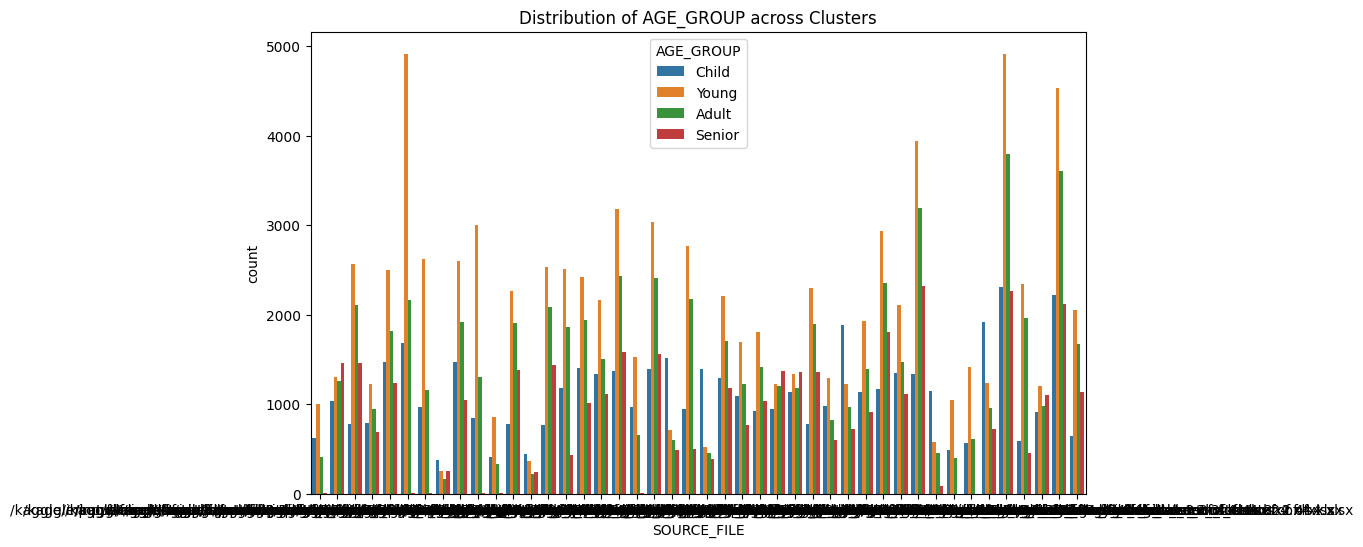

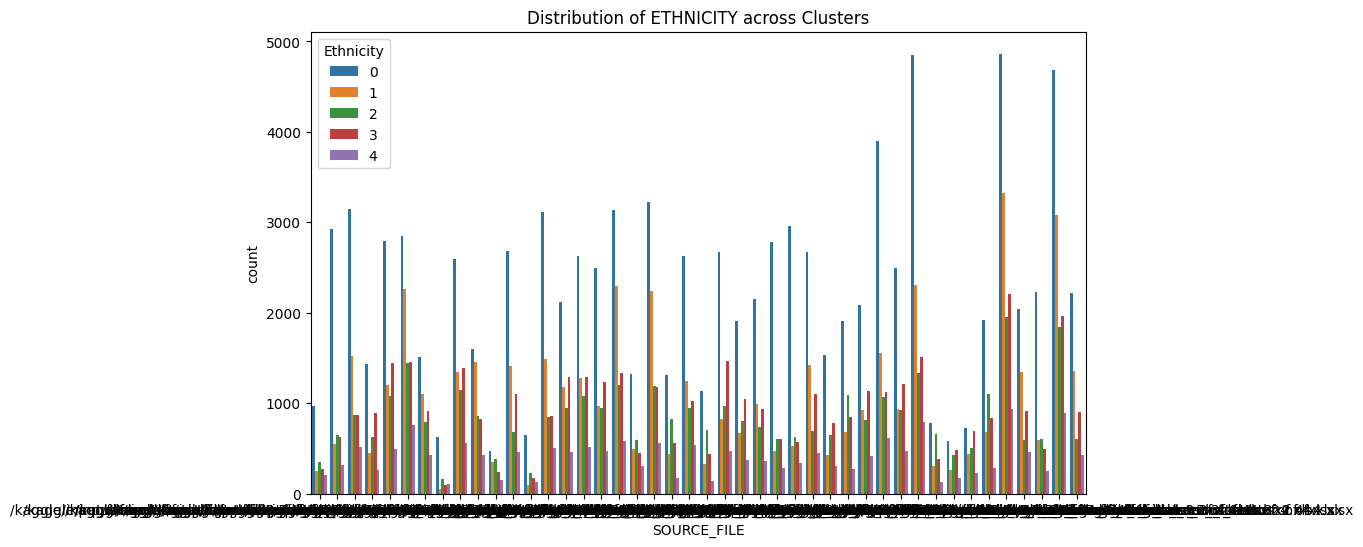

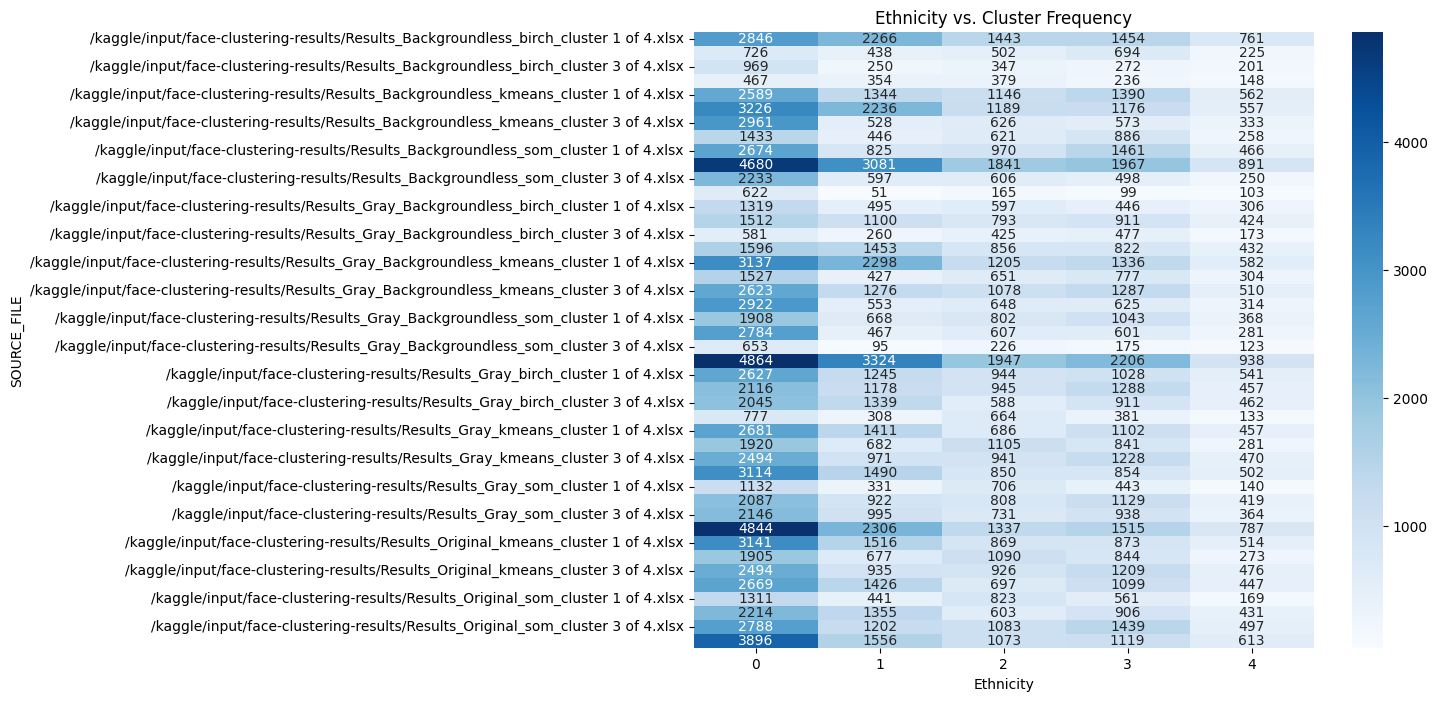

In [33]:
# ---- External Cluster Validity (ARI, NMI) ----
# Treat ETHNICITY as ground truth and CLUSTER as predicted
true_labels = all_data['Ethnicity']
pred_labels = all_data['SOURCE_FILE']

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
print("Adjusted Rand Index (ARI) based on ETHNICITY:", ari)
print("Normalized Mutual Information (NMI) based on ETHNICITY:", nmi)

# For AGE_GROUP
ari_age = adjusted_rand_score(all_data['AGE_GROUP'], pred_labels)
nmi_age = normalized_mutual_info_score(all_data['AGE_GROUP'], pred_labels)
print("ARI based on AGE_GROUP:", ari_age)
print("NMI based on AGE_GROUP:", nmi_age)

# ---- Visualizing distributions ----

# Distribution of AGE_GROUP per cluster
plt.figure(figsize=(10,6))
sns.countplot(x='SOURCE_FILE', hue='AGE_GROUP', data=all_data)
plt.title('Distribution of AGE_GROUP across Clusters')
plt.show()

# Distribution of ETHNICITY per cluster
plt.figure(figsize=(10,6))
sns.countplot(x='SOURCE_FILE', hue='Ethnicity', data=all_data)
plt.title('Distribution of ETHNICITY across Clusters')
plt.show()

# ---- Heatmap of Ethnicity Frequency per Cluster ----
ethnicity_cluster_counts = all_data.groupby(['SOURCE_FILE', 'Ethnicity']).size().unstack(fill_value=0)
plt.figure(figsize=(10,8))
sns.heatmap(ethnicity_cluster_counts, annot=True, fmt='d', cmap='Blues')
plt.title("Ethnicity vs. Cluster Frequency")
plt.show()


## Pixel Intensity Correlation


Analyzing Gray + kmeans...


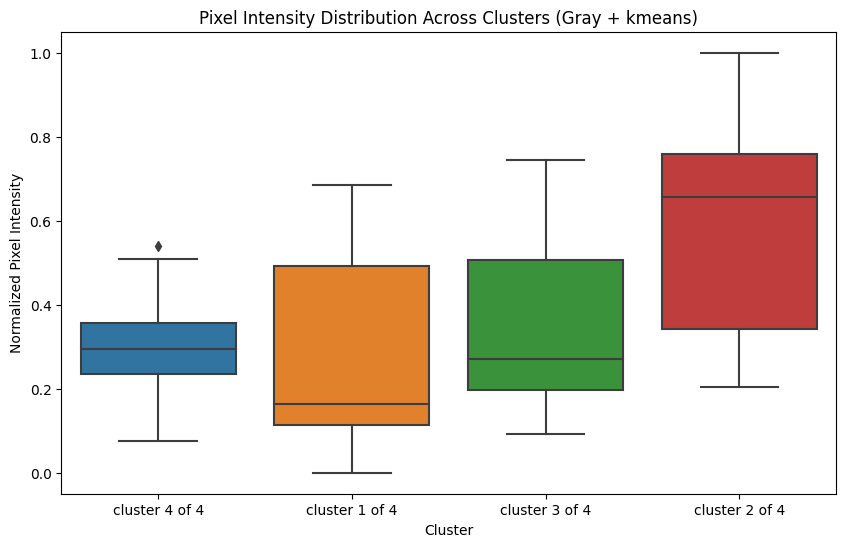

ANOVA F-statistic: 5869.945686209947, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Gray + som...


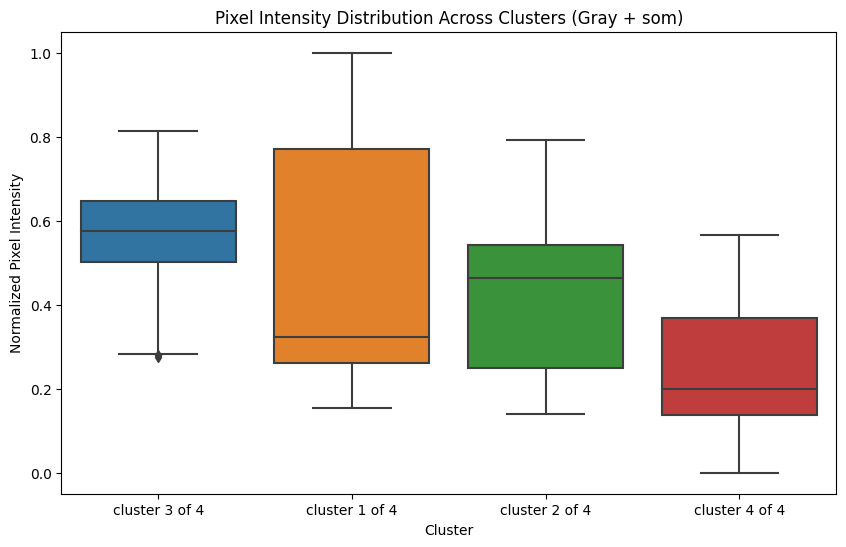

ANOVA F-statistic: 9210.188541613024, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Gray + birch...


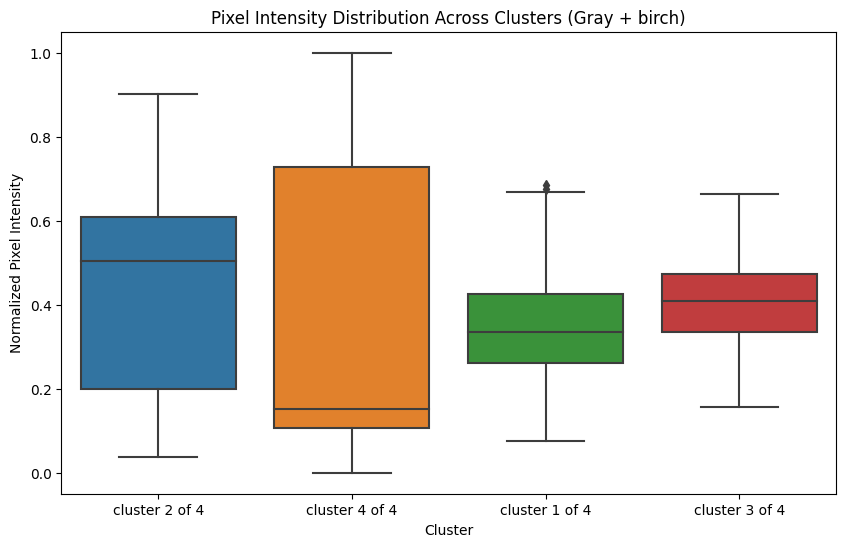

ANOVA F-statistic: 408.4984454710083, p-value: 7.67660904843656e-261
Significant difference in Pixel Intensity across clusters.

Analyzing Backgroundless + kmeans...


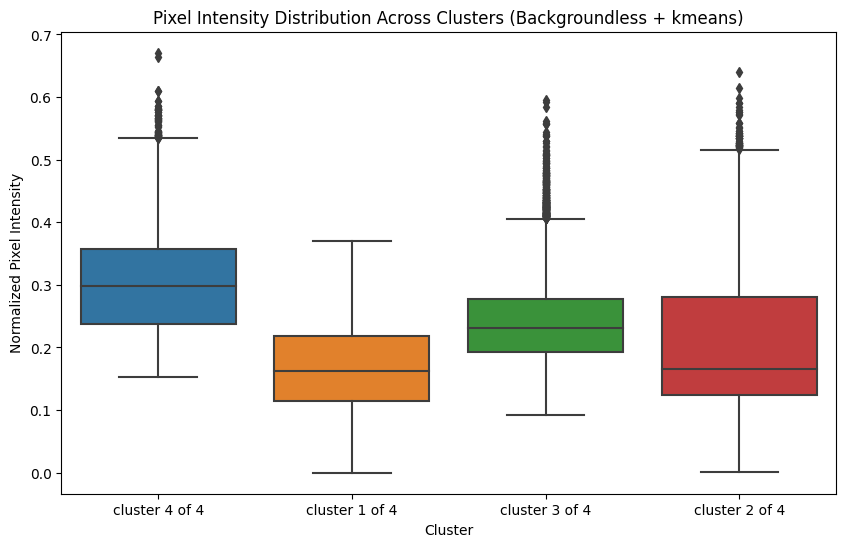

ANOVA F-statistic: 5786.839092553346, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Backgroundless + som...


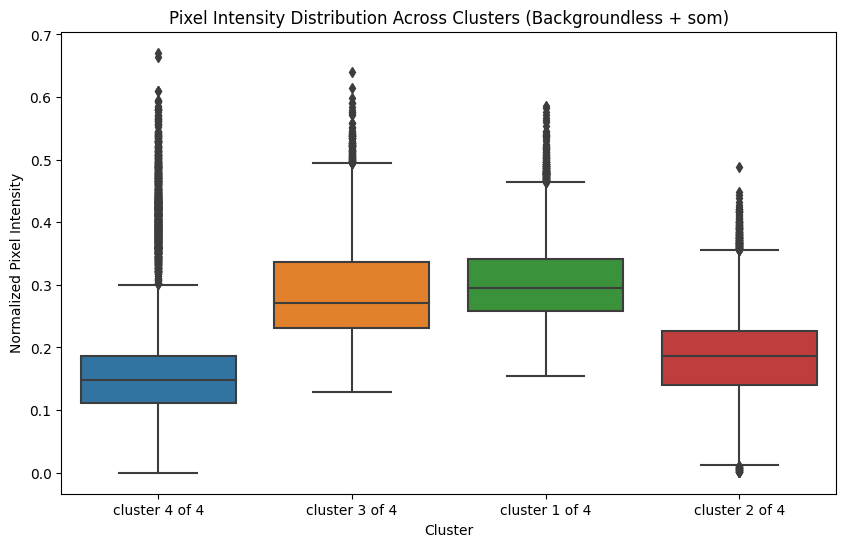

ANOVA F-statistic: 10423.151167553857, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Backgroundless + birch...


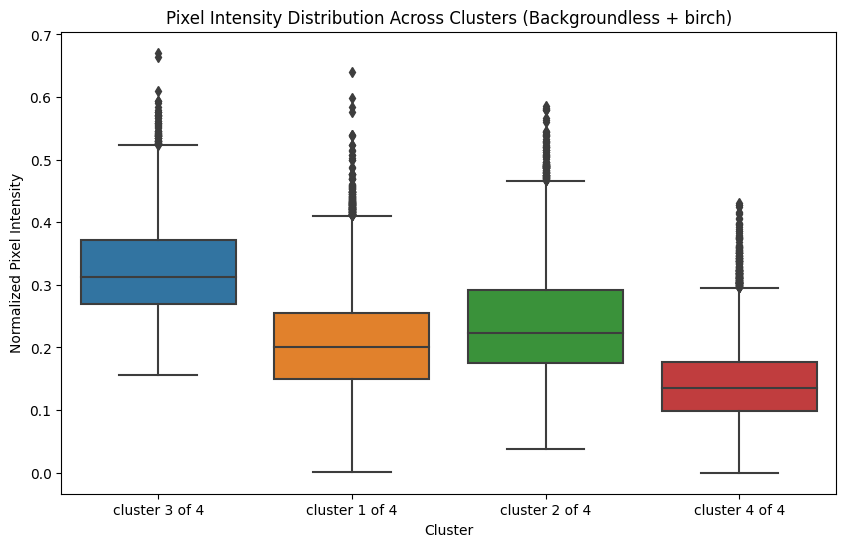

ANOVA F-statistic: 4826.770065529951, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Original + kmeans...


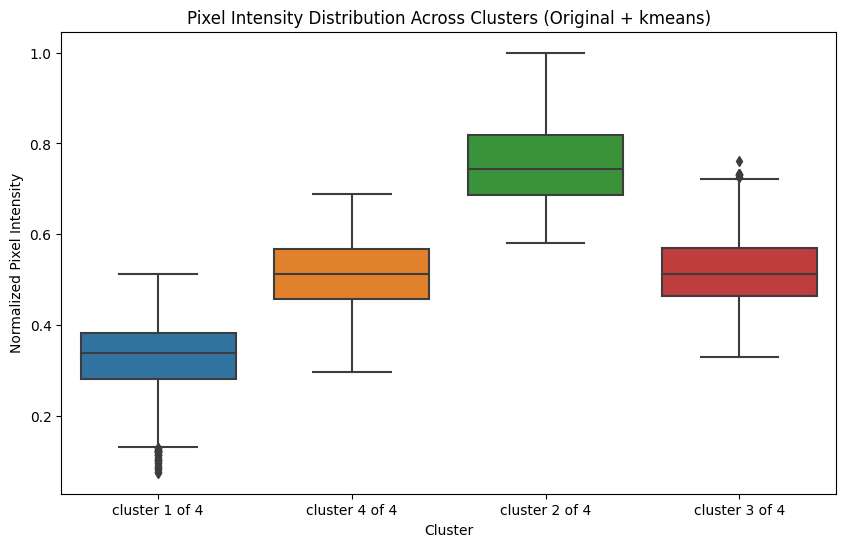

ANOVA F-statistic: 31028.579214466172, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Original + som...


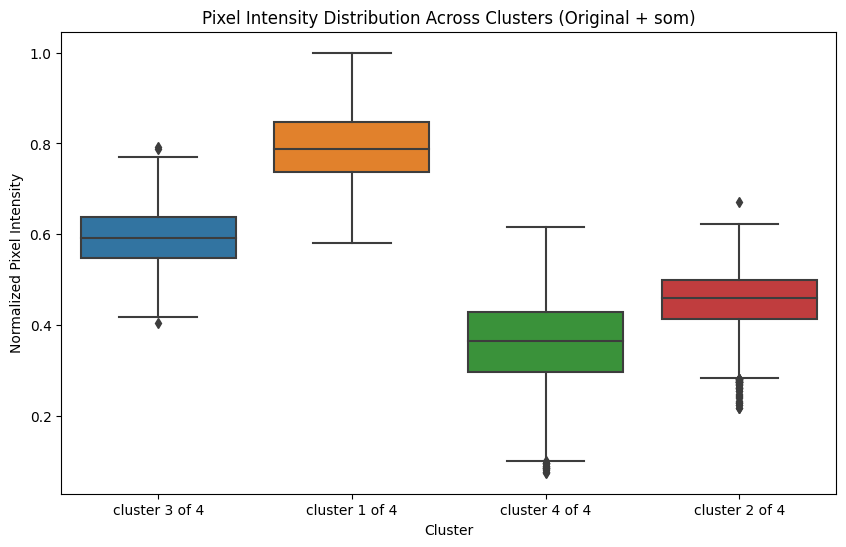

ANOVA F-statistic: 30178.335770701986, p-value: 0.0
Significant difference in Pixel Intensity across clusters.
No data found for Original + birch. Skipping...

Analyzing Gray_Backgroundless + kmeans...


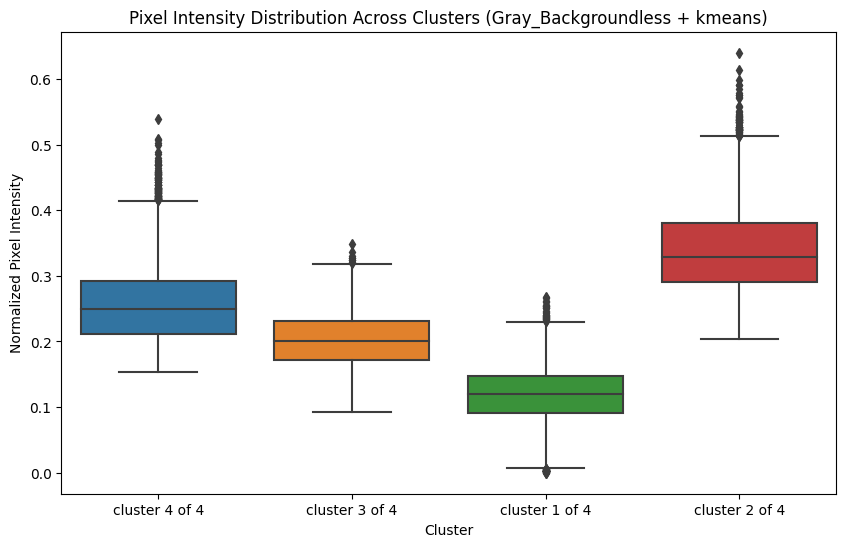

ANOVA F-statistic: 19681.501076694334, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Gray_Backgroundless + som...


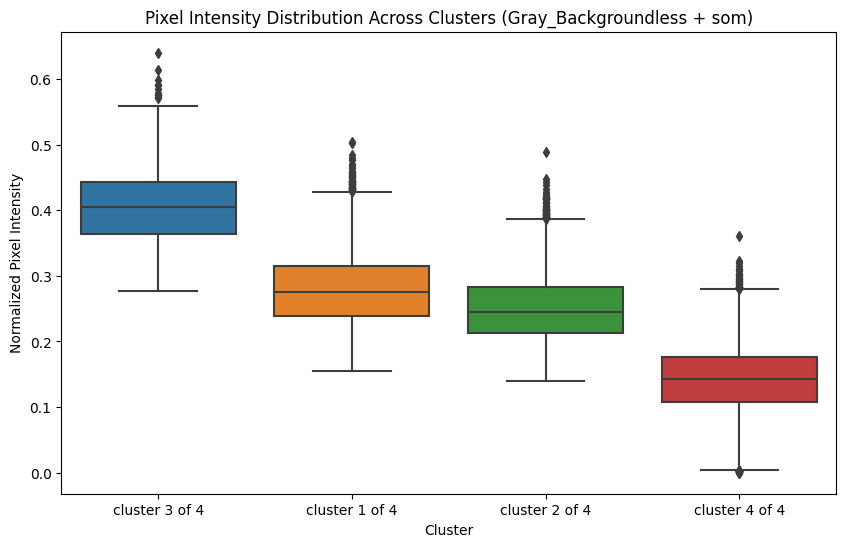

ANOVA F-statistic: 17647.27226502154, p-value: 0.0
Significant difference in Pixel Intensity across clusters.

Analyzing Gray_Backgroundless + birch...


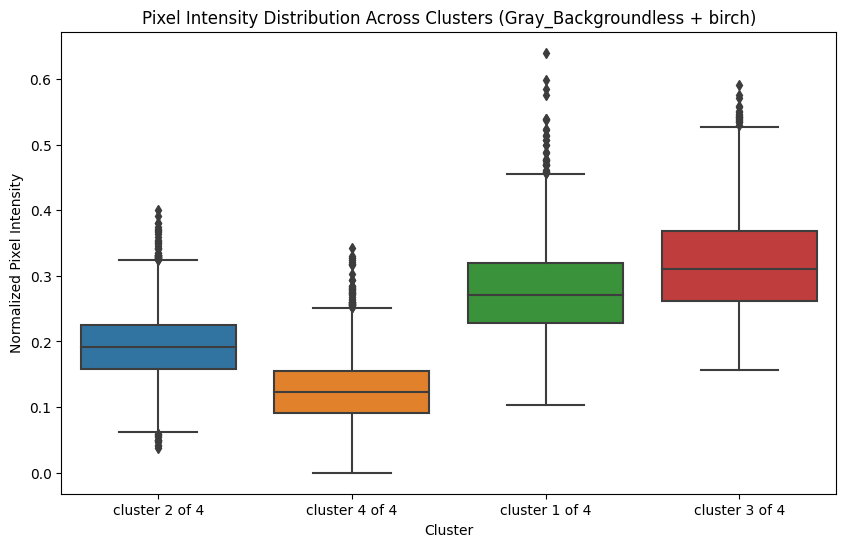

ANOVA F-statistic: 7346.033124564203, p-value: 0.0
Significant difference in Pixel Intensity across clusters.


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# List of datasets and algorithms
datasets = ["Gray", "Backgroundless", "Original","Gray_Backgroundless"]
algorithms = ["kmeans", "som", "birch"]
all_data['Cluster_Label'] = all_data['SOURCE_FILE'].apply(lambda x: x.split("_")[-1].split(".")[0])

# Analyze Pixel Intensity distribution and correlation for each dataset + algorithm
for dataset in datasets:
    for algorithm in algorithms:
        # Filter data for the specific dataset + algorithm
        subset = all_data[
            all_data['SOURCE_FILE'].str.contains(dataset, case=False) &
            all_data['SOURCE_FILE'].str.contains(algorithm, case=False)
        ]

        if subset.empty:
            print(f"No data found for {dataset} + {algorithm}. Skipping...")
            continue

        print(f"\nAnalyzing {dataset} + {algorithm}...")

        # Boxplot: Pixel Intensity Distribution Across Clusters
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster_Label', y='Pixel_Intensity_Normalized', data=subset)
        plt.title(f'Pixel Intensity Distribution Across Clusters ({dataset} + {algorithm})')
        plt.xlabel('Cluster')
        plt.ylabel('Normalized Pixel Intensity')
        plt.show()

        # Statistical Test: ANOVAz+
        cluster_groups = [group['Pixel_Intensity_Normalized'] for _, group in subset.groupby('Cluster_Label')]
        f_stat, p_value = f_oneway(*cluster_groups)
        print(f"ANOVA F-statistic: {f_stat}, p-value: {p_value}")
        if p_value < 0.05:
            print("Significant difference in Pixel Intensity across clusters.")
        else:
            print("No significant difference in Pixel Intensity across clusters.")

Correlation between Normalized Pixel Intensity and Ethnicity:
                            Pixel_Intensity_Normalized  Ethnicity
Pixel_Intensity_Normalized                    1.000000   0.007888
Ethnicity                                     0.007888   1.000000


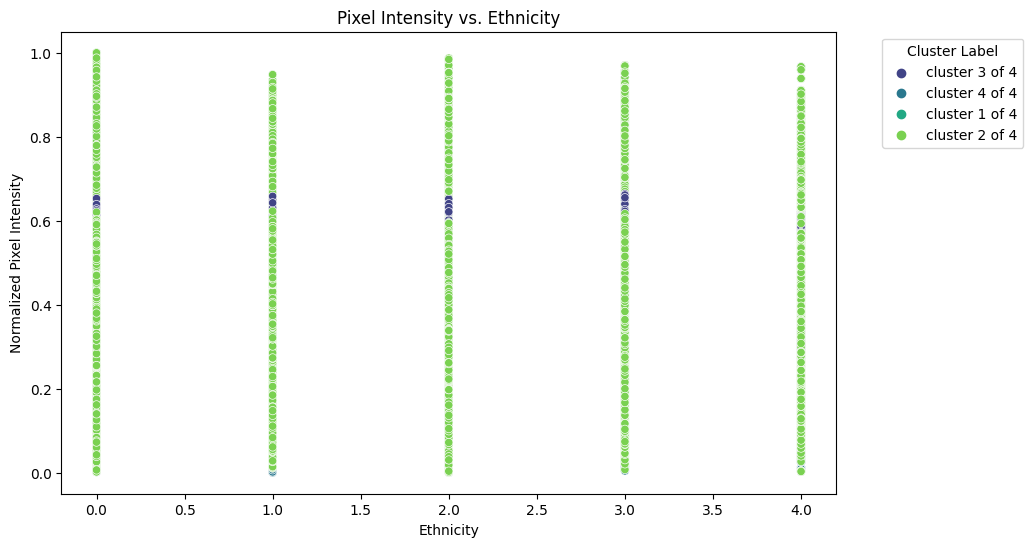

In [40]:
# Correlation between Pixel Intensity and Ethnicity
correlation_ethnicity = all_data[['Pixel_Intensity_Normalized', 'Ethnicity']].corr()
print("Correlation between Normalized Pixel Intensity and Ethnicity:")
print(correlation_ethnicity)

# Correlation Scatterplot: Pixel Intensity vs. Ethnicity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Ethnicity', y='Pixel_Intensity_Normalized', hue='Cluster_Label', data=all_data, palette='viridis'
)
plt.title('Pixel Intensity vs. Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Normalized Pixel Intensity')
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Silhouette

In [47]:
from sklearn.metrics import silhouette_score
import pandas as pd

# Function to compute Silhouette Score
def compute_silhouette(data, feature_columns, cluster_column):
    """
    Compute the Silhouette Score for the given dataset.
    
    Args:
    - data: DataFrame containing features and cluster assignments.
    - feature_columns: List of columns representing feature vectors.
    - cluster_column: Column name for cluster labels.
    
    Returns:
    - Silhouette Score
    """
    # Ensure all features are numeric
    X = data[feature_columns]  # Feature matrix as DataFrame
    X = X.dropna()  # Drop rows with NaN values

    # Ensure labels align with cleaned feature matrix
    labels = data.loc[X.index, cluster_column]  # Filter labels to match rows in X
    return silhouette_score(X.values, labels)

# Updated feature selection logic
results = []  # Store results for each dataset + algorithm

for dataset in datasets:
    for algorithm in algorithms:
        # Filter data for the specific dataset + algorithm
        subset = all_data[
            all_data['SOURCE_FILE'].str.contains(dataset, case=False) &
            all_data['SOURCE_FILE'].str.contains(algorithm, case=False)
        ]

        if subset.empty:
            print(f"No data found for {dataset} + {algorithm}. Skipping...")
            continue

        print(f"\nCalculating Silhouette Score for {dataset} + {algorithm}...")

        # Exclude non-feature columns
        feature_columns = [col for col in subset.columns if col not in ['SOURCE_FILE', 'Cluster_Label', 'Ethnicity', 'Age']]

        # Ensure only numeric columns are used
        numeric_features = subset[feature_columns].select_dtypes(include=[float, int]).columns.tolist()

        # Drop rows with missing values
        subset_cleaned = subset[numeric_features + ['Cluster_Label']].dropna()

        # Compute Silhouette Score
        silhouette = compute_silhouette(subset_cleaned, numeric_features, cluster_column='Cluster_Label')

        # Store the result
        results.append({
            "Dataset": dataset,
            "Algorithm": algorithm,
            "Silhouette_Score": silhouette
        })

        print(f"Silhouette Score for {dataset} + {algorithm}: {silhouette}")

# Save and Display Results
silhouette_results = pd.DataFrame(results)
print("\nSilhouette Score Results:")
print(silhouette_results)



Calculating Silhouette Score for Gray + kmeans...
Silhouette Score for Gray + kmeans: -0.019947120792586433

Calculating Silhouette Score for Gray + som...
Silhouette Score for Gray + som: 0.03347832015184308

Calculating Silhouette Score for Gray + birch...
Silhouette Score for Gray + birch: -0.07893011941419045

Calculating Silhouette Score for Backgroundless + kmeans...
Silhouette Score for Backgroundless + kmeans: -0.07277632081081785

Calculating Silhouette Score for Backgroundless + som...
Silhouette Score for Backgroundless + som: -0.012098263978151955

Calculating Silhouette Score for Backgroundless + birch...
Silhouette Score for Backgroundless + birch: -0.06570906223190609

Calculating Silhouette Score for Original + kmeans...
Silhouette Score for Original + kmeans: 0.2326497716656201

Calculating Silhouette Score for Original + som...
Silhouette Score for Original + som: 0.22199122986831124
No data found for Original + birch. Skipping...

Silhouette Score Results:
         